In [8]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd

In [9]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
# Check the train csv file to brainstorm what preprocessing is needed
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
train_df = train_df.drop('Name', axis=1)
train_df = train_df.drop('Cabin', axis=1)
train_df = train_df.drop('Ticket', axis=1)
test_df = test_df.drop('Name', axis=1)
test_df = test_df.drop('Cabin', axis=1)
test_df = test_df.drop('Ticket', axis=1)
# Replace the relevant but string data with floats or ints
train_df['Sex'] = train_df['Sex'].replace({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].replace({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].replace({'S': 1, 'C': 2, 'Q': 3})
test_df['Embarked'] = test_df['Embarked'].replace({'S': 1, 'C': 2, 'Q': 3})

In [12]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(0)
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())
# Check that the train data is mostly preprocessed
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 62.8 KB


In [13]:
train_df.corrwith(train_df['Survived'])

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.064910
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Embarked       0.101849
dtype: float64

In [14]:
train_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,1.359147
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.638707
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [15]:
train_df = train_df.sample(frac=1)
dev_df = train_df.iloc[691:]

In [16]:
dev_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,430.935000,0.360000,2.32000,0.330000,29.698750,0.555000,0.395000,33.568270,1.405000
std,263.409841,0.481205,0.83732,0.471393,12.903373,1.351335,0.912765,53.419533,0.687998
min,5.000000,0.000000,1.00000,0.000000,0.750000,0.000000,0.000000,0.000000,1.000000
25%,194.750000,0.000000,2.00000,0.000000,22.000000,0.000000,0.000000,8.050000,1.000000
50%,407.500000,0.000000,3.00000,0.000000,28.000000,0.000000,0.000000,14.500000,1.000000
75%,650.500000,1.000000,3.00000,1.000000,34.250000,1.000000,0.000000,31.275000,2.000000
max,888.000000,1.000000,3.00000,1.000000,71.000000,8.000000,6.000000,512.329200,3.000000


In [17]:
class TitanicDataset(Dataset):
    def __init__(self, data_frame):
        length = data_frame.shape[1]
        x_tmp = np.array(data_frame.iloc[:, 2:length])
        y_tmp = np.array(data_frame.iloc[:, 1])
        self.x_data = torch.from_numpy(x_tmp).float()
        self.y_data = torch.from_numpy(y_tmp).long()

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        x_idx = self.x_data[idx]
        y_idx = self.y_data[idx]
        return x_idx, y_idx

In [18]:
train_data = TitanicDataset(train_df)
dev_data = TitanicDataset(dev_df)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)
dev_dataloader = DataLoader(dev_data, batch_size=32, shuffle=False)

for X, Y in train_dataloader:
    print(f"train_X shape: {X.shape} // train_Y shape: {Y.shape} {Y.dtype}")

train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: torch.Size([32, 7]) // train_Y shape: torch.Size([32]) torch.int64
train_X shape: t

In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        drop_out_rate = 0

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 15),
            nn.ReLU(),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 5),
            nn.ReLU(),
            nn.Linear(5, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=15, out_features=15, bias=True)
    (4): ReLU()
    (5): Linear(in_features=15, out_features=5, bias=True)
    (6): ReLU()
    (7): Linear(in_features=5, out_features=2, bias=True)
  )
)


In [24]:
weights = torch.tensor([1., 2.])
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)

In [25]:
def train(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0
    for batch, (sequences, targets) in enumerate(dataloader):
        sequences, targets = sequences.to(device), targets.to(device)

        # Compute prediction error
        pred = model(sequences)
        loss = loss_fn(pred, targets)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / (batch + 1)

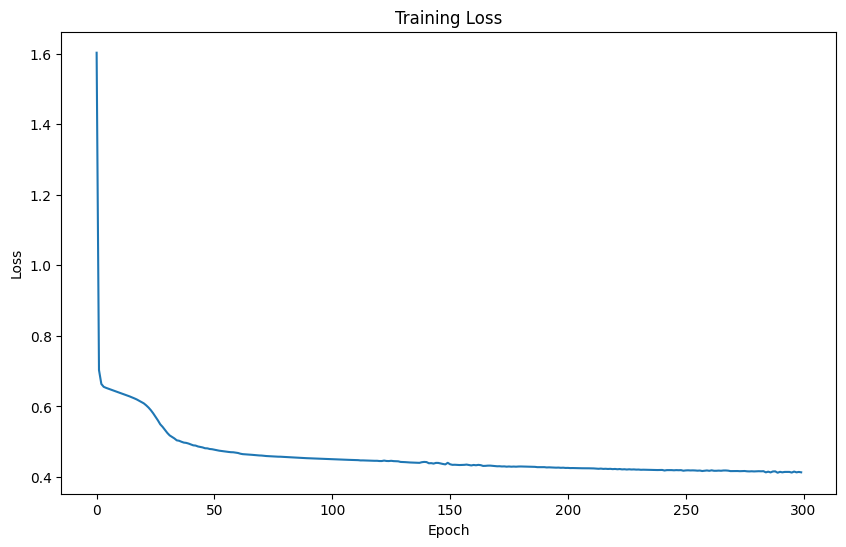

In [26]:
num_epochs = 300
losses = []


for epoch in range(num_epochs):
    loss = train(train_dataloader, model, loss_fn, optimizer, device)

    # Append losses for plotting losses
    losses.append(loss)

# Show the loss graph
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [28]:
def validate(dataloader, model, loss_fn, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()
            correct += ((pred.argmax(1).reshape(-1, 1)) == (Y.reshape(-1, 1))).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return str(f"Accuracy: {(100 * correct):>0.1f}%, Size: {int(size)} \n"
               f"Avg loss: {test_loss:>8f} \n ")

In [29]:
print(validate(train_dataloader, model, loss_fn, device))
print(validate(dev_dataloader, model, loss_fn, device))

Accuracy: 80.6%, Size: 891 
Avg loss: 0.407772 
 
Accuracy: 79.5%, Size: 200 
Avg loss: 0.400045 
 
